In [33]:
#importing the required dependencies
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.compiler.tensorrt import trt_convert as trt
from tensorflow.python.saved_model import tag_constants
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [51]:
#Downloading the images for inference

!wget -O img0.jpg https://img.etimg.com/thumb/msid-78315445,width-650,imgsize-297446,,resizemode-4,quality-100/young-people-within-the-age-group-26-35-years-believe-that-social-distancing-suffices-as-a-preventive-measure-.jpg
!wget -O img1.jpg https://images.news.iu.edu/dams/ngeskt3qtg_w1024.jpg
!wget -O img2.jpg https://imagevars.gulfnews.com/2020/07/14/WEB-200714-INDIA-MASK23-1594725917228_1734d12622d_original-ratio.jpg

--2021-10-09 23:38:01--  https://img.etimg.com/thumb/msid-78315445,width-650,imgsize-297446,,resizemode-4,quality-100/young-people-within-the-age-group-26-35-years-believe-that-social-distancing-suffices-as-a-preventive-measure-.jpg
Resolving img.etimg.com (img.etimg.com)... 104.98.95.184, 2600:1407:21:19b::216f, 2600:1407:21:182::216f
Connecting to img.etimg.com (img.etimg.com)|104.98.95.184|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 140846 (138K) [image/jpeg]
Saving to: ‘img0.jpg’

img0.jpg            100%[===================>] 137.54K  --.-KB/s    in 0.03s   

2021-10-09 23:38:02 (4.72 MB/s) - ‘img0.jpg’ saved [140846/140846]

--2021-10-09 23:38:02--  https://images.news.iu.edu/dams/ngeskt3qtg_w1024.jpg
Resolving images.news.iu.edu (images.news.iu.edu)... 129.79.123.148, 129.79.123.149, 2001:18e8:2:e::104, ...
Connecting to images.news.iu.edu (images.news.iu.edu)|129.79.123.148|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3

In [52]:
#pre-processing 1st image to pass into the model
img = tf.keras.preprocessing.image.load_img('img0.jpg', target_size=(224, 224))
x = tf.keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = tf.keras.applications.resnet50.preprocess_input(x)

In [37]:
#pre-processing 2nd image to pass into the model
img = tf.keras.preprocessing.image.load_img('img1.jpg', target_size=(224, 224))
x1 = tf.keras.preprocessing.image.img_to_array(img)
x1 = np.expand_dims(x1, axis=0)
x1 = tf.keras.applications.resnet50.preprocess_input(x1)

In [38]:
#pre-processing 3rd image to pass into the model
img = tf.keras.preprocessing.image.load_img('img2.jpg', target_size=(224, 224))
x2 = tf.keras.preprocessing.image.img_to_array(img)
x2 = np.expand_dims(x2, axis=0)
x2 = tf.keras.applications.resnet50.preprocess_input(x2)

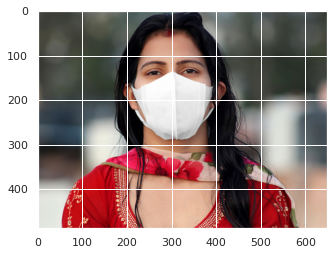

In [53]:
#looking at the downloaded images
image_1 = plt.imread('img0.jpg')
plt.imshow(image_1)
plt.show()

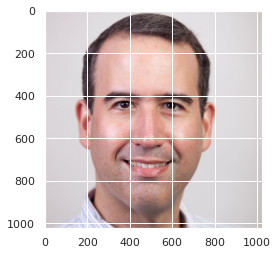

In [40]:
#looking at the downloaded images
image_1 = plt.imread('img1.jpg')
plt.imshow(image_1)
plt.show()

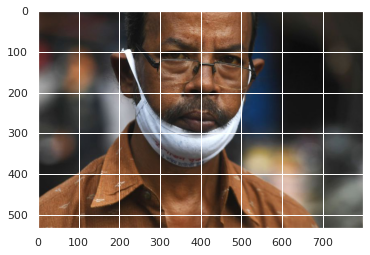

In [41]:
#looking at the downloaded images
image_1 = plt.imread('img2.jpg')
plt.imshow(image_1)
plt.show()

In [15]:
# Defining the Precision in which we want to convert
params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(
  precision_mode='FP16',)

In [18]:
# Converting our model to Tensorrt using TF-TRT 
converter = trt.TrtGraphConverterV2(
      input_saved_model_dir='resnet50_face_mask_new',
      conversion_params=params)
converter.convert()

INFO:tensorflow:Linked TensorRT version: (0, 0, 0)
INFO:tensorflow:Loaded TensorRT version: (0, 0, 0)


<ConcreteFunction pruned(input_2) at 0x7FBC33D60A50>

In [19]:
saved_model_dir_trt = 'resnet50_face_mask.trt'
converter.save(saved_model_dir_trt)

INFO:tensorflow:Assets written to: resnet50_face_mask.trt/assets


In [42]:
#loading the optimized tf-trt model and it's serving default
infer = tf.saved_model.load(saved_model_dir_trt)
concrete_func = infer.signatures['serving_default']

In [43]:
# Looking at the meta data of the model and serving_default (Note: please not the output node info in our model the output node name is : dense_1)
!saved_model_cli show --all --dir resnet50_face_mask.trt/


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_2'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 224, 224, 3)
        name: serving_default_input_2:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 3)
        name: PartitionedCall:0
  Method name is: tensorflow/serving/predict
W1009 23:34:02.760481 140142685861760 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/tensorflow_core/python/ops/resource_

In [54]:
# Inferencing using the optimized tf-trt model and getting the predictions
labeling = concrete_func(tf.constant(x.astype('float32')))
activations = tf.nn.softmax(labeling['dense_1'])
class_names = ['Incorrect Mask','Mask','No Mask']
string = "This particular image most likely is :"+class_names[np.argmax(activations)]
print(string)

This particular image most likely is :Mask


In [45]:
# Inferencing using the optimized tf-trt model and getting the predictions
labeling = concrete_func(tf.constant(x1.astype('float32')))
activations = tf.nn.softmax(labeling['dense_1'])
class_names = ['Incorrect Mask','Mask','No Mask']
string = "This particular image most likely is :"+class_names[np.argmax(activations)]
print(string)

This particular image most likely is :No Mask


In [46]:
# Inferencing using the optimized tf-trt model and getting the predictions
labeling = concrete_func(tf.constant(x2.astype('float32')))
activations = tf.nn.softmax(labeling['dense_1'])
class_names = ['Incorrect Mask','Mask','No Mask']
string = "This particular image most likely is :"+class_names[np.argmax(activations)]
print(string)

This particular image most likely is :Incorrect Mask
